In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

[2018-07-24 23:18:37,291] Making new env: CartPole-v0
[2018-07-24 23:18:37,293] Making new env: CartPole-v0
[2018-07-24 23:18:37,295] Making new env: CartPole-v0
[2018-07-24 23:18:37,299] Making new env: CartPole-v0
[2018-07-24 23:18:37,302] Making new env: CartPole-v0
[2018-07-24 23:18:37,334] Making new env: CartPole-v0
[2018-07-24 23:18:37,311] Making new env: CartPole-v0
[2018-07-24 23:18:37,310] Making new env: CartPole-v0
[2018-07-24 23:18:37,313] Making new env: CartPole-v0
[2018-07-24 23:18:37,326] Making new env: CartPole-v0
[2018-07-24 23:18:37,330] Making new env: CartPole-v0
[2018-07-24 23:18:37,332] Making new env: CartPole-v0
[2018-07-24 23:18:37,331] Making new env: CartPole-v0
[2018-07-24 23:18:37,336] Making new env: CartPole-v0
[2018-07-24 23:18:37,336] Making new env: CartPole-v0
[2018-07-24 23:18:37,338] Making new env: CartPole-v0
[2018-07-24 23:18:37,455] Making new env: CartPole-v0


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [6]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        # this is operating on 16 envs at once
        # if mask is false (implying done) then reward for that step should just be the reward for that move. No future.
        R = rewards[step] + R * gamma * masks[step]
        returns.insert(0, R)
    return returns

In [7]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr)

In [8]:
max_frames   = 20000
frame_idx    = 0
test_rewards = []

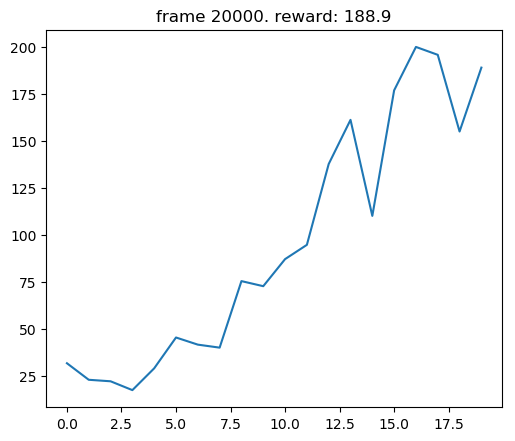

In [9]:
state = envs.reset()

while frame_idx < max_frames:
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    
    for _ in range(num_steps):
        # state is 16 x 4 because 16 envs
        state = torch.FloatTensor(state).to(device)
        # dist and value each have 16 for all envs
        dist, value = model(state)
        
        # have 16 actions
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        
        log_prob = dist.log_prob(action)
        # need to do mean b/c have 16
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        # there are 16 rewards. Need to make it 16x1. Same for masks
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
                
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()